In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('./sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [2]:
%%writefile data/sq.py
"""2D flow around a square cylinder in a channel.

Lift and drag coefficients of the cylinder are measured using the
momentum exchange method.

Fully developed parabolic profile is prescribed at the inflow and
a constant pressure condition is prescribed at the outflow.

The results can be compared with:
    [1] M. Breuer, J. Bernsdorf, T. Zeiser, F. Durst
    Accurate computations of the laminar flow past a square cylinder
    based on two different methods: lattice-Boltzmann and finite-volume
    Int. J. of Heat and Fluid Flow 21 (2000) 186-196.
"""

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

# Geometry set to match [1].
H = 180
L = int(6.25 * H)
D = int(0.02 * L)

# St = f D / u_max

class BoxSubdomain(Subdomain2D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)


class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'precision': 'single',
            'max_iters': 1000000,
            'visc': 0.05})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)

    def record_value(self, iteration, force, C_D, C_L):
        print iteration, force[0], force[1], C_D, C_L

    prev_f = None
    every = 500
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f



ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


Overwriting data/sq.py


In [ ]:
%%writefile data/sq.py
"""2D flow around a channel.


"""

import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity, NTEquilibriumDensity, DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_base import ForceObject
from sailfish.lb_single import LBFluidSim
from sailfish.sym import S

# Geometry set to match [1].
H = 4*180
L = int(6.25/4 * H)
D = int(0.02 * L)

# St = f D / u_max

class BoxSubdomain(Subdomain2D):
    bc = NTHalfBBWall
    max_v = 0.05

    def boundary_conditions(self, hx, hy):
        walls = (hy == 0) | (hy == self.gy - 1)
        self.set_node(walls, self.bc)

        hhy = S.gy - self.bc.location
        self.set_node((hx == 0) & np.logical_not(walls),
                      NTEquilibriumVelocity(
                          DynamicValue(4.0 * self.max_v / H**2 * hhy * (H - hhy), 0.0)))
        self.set_node((hx == self.gx - 1) & np.logical_not(walls),
                      NTEquilibriumDensity(1))
        l = L / 4

        # Full bounce-back. For N box nodes, effective size is N+1.
        if self.bc.location == 0.5:
            eff_D = D - 1
        # Half-way bounce-back. For N box nodes, effective size is N-2.
        else:
            eff_D = D + 2

        box = ((hx > l - eff_D / 2.0) & (hx <= l + eff_D / 2.0) &
               (hy > (H - eff_D) / 2.0) & (hy <= (H + eff_D) / 2.0))
        self.set_node(box, self.bc)

    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        sim.vy[:] = 0.0

        hhy = hy - self.bc.location
        sim.vx[:] = 4.0 * self.max_v / H**2 * hhy * (H - hhy)


class BoxSimulation(LBFluidSim):
    subdomain = BoxSubdomain

    @classmethod
    def update_defaults(cls, defaults):
        defaults.update({
            'lat_nx': L,
            'lat_ny': (H + 2 if BoxSubdomain.bc.location == 0.5 else H),
            'precision': 'single',
            'max_iters': 1000000,
            'model':'mrt',
            'visc': 0.005})

    def __init__(self, *args, **kwargs):
        super(BoxSimulation, self).__init__(*args, **kwargs)

        margin = 5
        self.add_force_oject(ForceObject(
            (L / 4 - D / 2 - margin, (H - D) / 2 - margin),
            (L / 4 + D / 2 + margin, (H + D) / 2 + margin)))

        print '%d x %d | box: %d' % (L, H, D)
        print 'Re = %2.f' % (BoxSubdomain.max_v * D / self.config.visc)

    def record_value(self, iteration, force, C_D, C_L):
        print iteration, force[0], force[1], C_D, C_L

    prev_f = None
    every = 500
    def after_step(self, runner):
        if self.iteration % self.every == 0:
            runner.update_force_objects()
            for fo in self.force_objects:
                runner.backend.from_buf(fo.gpu_force_buf)
                f = fo.force()

                # Compute drag and lift coefficients.
                C_D = (2.0 * f[0] / (D * BoxSubdomain.max_v**2))
                C_L = (2.0 * f[1] / (D * BoxSubdomain.max_v**2))
                self.record_value(runner._sim.iteration, f, C_D, C_L)

                if self.prev_f is None:
                    self.prev_f = np.array(f)
                else:
                    f = np.array(f)

                    # Terminate simulation when steady state has
                    # been reached.
                    diff = np.abs(f - self.prev_f) / np.abs(f)

                    if np.all(diff < 1e-6):
                        runner._quit_event.set()
                    self.prev_f = f



ctrl = LBSimulationController(BoxSimulation)
ctrl.run()


In [3]:
%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python data/sq.py --max_iters=100000 --every=1000 --from=0000 \
 --output=data/sq --output_format=npy  

1125 x 180 | box: 22
Re = 22
500 0.102992139757 -0.000458978116512 3.74516871842 -0.0166901133277
1000 0.113136995584 -0.00136445835233 4.11407256668 -0.0496166673574
1500 0.0746518187225 -0.00123564526439 2.71461158991 -0.0449325550686
2000 0.0544052794576 -0.000559478998184 1.97837379846 -0.0203446908431
2500 0.066022220999 0.000655766576529 2.40080803633 0.0238460573283
3000 0.0844321846962 0.00144191086292 3.07026126168 0.0524331222881
3500 0.0614841654897 -0.000680908560753 2.23578783599 -0.0247603113001
4000 0.0303980559111 -0.000124976038933 1.10538385131 -0.00454458323392
4500 0.0623387061059 0.000249836593866 2.26686204022 0.00908496704969
5000 0.0721224322915 0.000291720032692 2.62263390151 0.0106080011888
5500 0.0477322116494 7.59810209274e-05 1.73571678725 0.00276294621554
6000 0.0589315257967 1.89878046513e-05 2.14296457442 0.000690465623682
6500 0.0656827799976 -5.8226287365e-06 2.38846472718 -0.000211731954054
7000 0.0555217601359 -0.000176940113306 2.01897309585 -0.0064

[   751  INFO Master/GPU2] Machine master starting with PID 141675 at 2016-06-13 14:22:44 UTC
[   751  INFO Master/GPU2] Simulation started with: data/sq.py --max_iters=100000 --every=1000 --from=0000 --output=data/sq --output_format=npy
[   765  INFO Master/GPU2] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   765  INFO Master/GPU2] Handling subdomains: [0]
[   765  INFO Master/GPU2] Subdomain -> GPU map: {0: 0}
[   765  INFO Master/GPU2] Selected backend: cuda
[  1004  INFO Subdomain/0] Initializing subdomain.
[  1006  INFO Subdomain/0] Required memory: 
[  1006  INFO Subdomain/0] . distributions: 14 MiB
[  1006  INFO Subdomain/0] . fields: 2 MiB
[  4268  INFO Subdomain/0] Processing force objects.
[  4350  INFO Subdomain/0] Starting simulation.
[  4781  INFO Subdomain/0] iteration:2000  speed:712.66 MLUPS
[  5084  INFO Subdomain/0] iteration:3000  speed:661.80 MLUPS
[  5381  INFO Subdomain/0] iteration:4000  speed:681.06 MLUPS
[  5677  INFO Subdomain/0] iteration:5000

In [ ]:
%%sh
rm data/sq*npz
export PYTHONPATH=$PWD/sailfish/
python sq.py --max_iters=100000 --every=100 --from=90000 \
 --output=data/sq --output_format=npy  

In [4]:
%%time 
import glob
frames = []
s = (slice(None),slice(None))
#s = (slice(80,170,1),slice(20,220,1))
#s = (slice(None),slice(None,200,1))

for fn in sorted(glob.glob("data/sq.*.npz")):
    data =np.load(fn)
    vx,vy = data['v']
    rho = data['rho']
    vx, vy  = vx[s],vy[s]
    Dxvx,Dyvx = np.gradient(vx)
    Dxvy,Dyvy = np.gradient(vy)
    frames.append([vx, vy,Dyvx-Dxvy,rho])
print len(frames)

101
CPU times: user 1.66 s, sys: 232 ms, total: 1.9 s
Wall time: 1.89 s


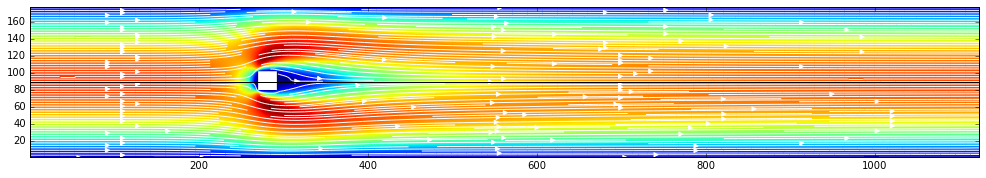

0.0585261


In [5]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0)\
         ,stream=widgets.FloatSlider(value=0.0,min=0.0,max=4.0,step=0.1,description='streamlines density:',
)
         )
def g(ith,figsize,sel,stream):
    
    plt.figure(figsize=(figsize,float(ny)/nx*figsize))
    vx,vy=frames[ith][:2]
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')#,vmin=-0.1,vmax=0.1)
    if stream>0:
        plt.streamplot(X,Y,vx,vy,color='white',density=stream)
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    plt.show() 
    print np.nanmax(vx)

-c:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


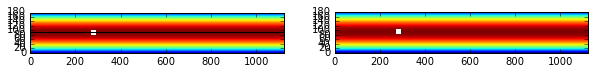

0.0499985


In [6]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets
ny,nx = frames[0][0].shape
Y,X = np.mgrid[0:ny,0:nx]

@interact(ith=widgets.IntSlider(min=0,max=len(frames)-1),\
          figsize=widgets.IntSlider(min=0,max=20,value=10),\
          sel=widgets.Dropdown(options={'vx':0, 'vy': 1, 'rot v': 2,'rho':3},value=0)\
         ,stream=widgets.FloatSlider(value=0.0,min=0.0,max=4.0,step=0.1,description='streamlines density:',
),
          wx = widgets.FloatRangeSlider(value=(0,nx-1),min=0,max=nx-1,step=1),
        wy = widgets.FloatRangeSlider(value=(0,ny-1),min=0,max=ny,  step=1)
         )
def g(ith,figsize,sel,stream,wx,wy):
    
    plt.figure(figsize=(figsize,2*float(ny)/nx*figsize))
    s = (slice(wy[0],wy[1],1),slice(wx[0],wx[1],1))
    vx,vy=frames[ith][:2]
    plt.subplot(1,2,1)
    plt.xlim(1,nx-2)
    plt.ylim(1,ny-2) 
    plt.imshow(frames[ith][sel],origin='top')
    plt.axhline(y=ny/2, xmin=0, xmax=40, linewidth=1, color = 'k')
    
    plt.subplot(1,2,2)
    plt.xlim(wx[0],wx[1])
    plt.ylim(wy[0],wy[1]) 
    plt.imshow(frames[ith][sel][s],origin='top',extent=(wx[0],wx[1],wy[0],wy[1]))
    if stream>0:
        plt.streamplot(X[s],Y[s],vx[s],vy[s],color='white',density=stream)
    plt.show() 
    print np.nanmax(vx)



In [ ]:
wx.values

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(frames[1][0][:,0])

plt.subplot(1,2,2)
plt.plot(frames[1][0][:,250])

In [ ]:
display?